## Digit Classification With Multi Layered Perceptron

Import Libraries and Load Data

In [1]:
import torch
import torch.nn as nn
from torch.nn import Dropout
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# define path to store data
trainset_path = '/Users/seangorman/code-projects/deep-digits/trainset'
testset_path = '/Users/seangorman/code-projects/deep-digits/testset'

# check if trainset and testset already exist at the specified paths
def download_data(path):
    if not os.path.exists(path):
        data = datasets.MNIST(path, download=True, train=True, transform=transform)
        print('Trainset downloaded')
        return data
    else:
        data = datasets.MNIST(path, train=True, transform=transform)
        print('Trainset already exists')
        return data

trainset = download_data(trainset_path)
testset = download_data(testset_path)



Trainset already exists
Trainset already exists


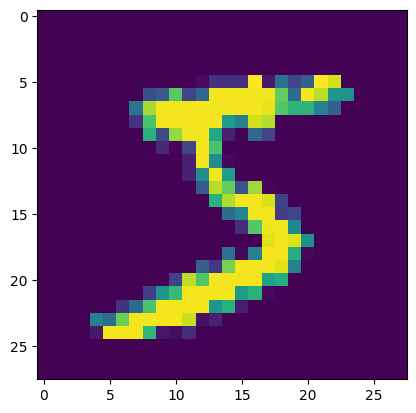

In [2]:
image, label = trainset[0]

# convert the tensor back to an image
image = transforms.ToPILImage()(image)

# display the image
plt.imshow(image)
plt.show()

In [3]:
#the number of objects in the tensor is the number of pixels in the image
input_dims = trainset[0][0].numel()
input_dims

784

In [4]:
#determine the number of classes (output_dims)
output_dims = len(set(trainset.targets.numpy()))
output_dims


10

Construct MLP

In [5]:
input_dims = 784
output_dims = 10


class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dims, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dims)
        self.dropout = Dropout(p=0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
    

model = MLP()
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) #prints params



109386


Main Training Loop

In [6]:
# define a loss function
criterion = nn.NLLLoss()

# define an optimizer
adam = torch.optim.Adam(model.parameters(), lr=0.003)   

# Use a data loader to automatically generate batches for training (Can iterate over these/Memory efficient)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

losses = []

#Main training loop
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        adam.zero_grad()    #clear gradients for each batch
        log_ps = model(images)  #forward pass (predict image class and get log probabilities)
        loss = criterion(log_ps, labels)    #calculate loss (avg loss for all images in batch)
        loss.backward()  #backpropagate loss
        adam.step()     #use optimiser to update model weights
        running_loss += loss.item()     #track loss for each batch
        avg_loss = running_loss/len(trainloader)   #calculate average loss for each epoch
        
    else:
        losses.append(avg_loss)
        print(f"Training loss: {avg_loss}")

Training loss: 0.4695545015479329
Training loss: 0.29037520920099225
Training loss: 0.25756593589891374
Training loss: 0.2396807217799715
Training loss: 0.23262140056344746
Training loss: 0.21971314584316093
Training loss: 0.21682621324176726
Training loss: 0.20521390201774106
Training loss: 0.20666440949439685
Training loss: 0.19953322295806428


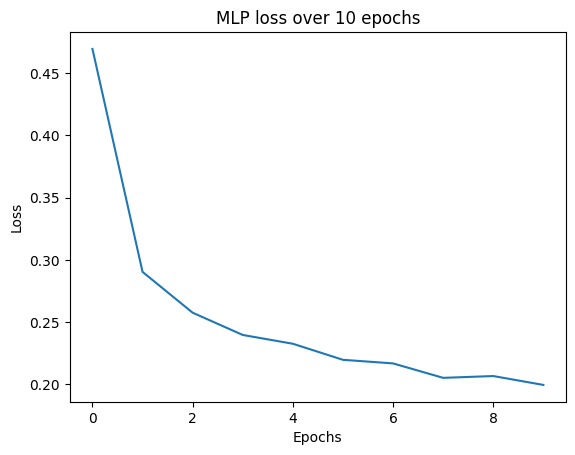

In [15]:
# Plot the loss
plt.plot(losses)
plt.title('MLP loss over 10 epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig('loss-over-time.png', dpi=120) 


In [8]:
# Visualising data batching
batch_X, batch_y = next(iter(trainloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f"  y: {batch_y[0]}")

Sample batch:
  X: [64, 1, 28, 28]
  y: [64]
Sample point:
  X: tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1

Make Predictions and Evaluate Model

In [9]:
# Make predictions on test set
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    model.eval()        #set model to evaluation mode to turn off dropout, ensures model is using learned weights
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:
        pred_probs = model(images)   #forward pass prediction probabibilities
        test_loss += criterion(pred_probs, labels)          
        ps = torch.exp(pred_probs)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    print(f"Test loss: {test_loss/len(testloader)}")
    print(f"Test accuracy: {accuracy/len(testloader)}")


Test loss: 0.10788818448781967
Test accuracy: 0.9676839113235474


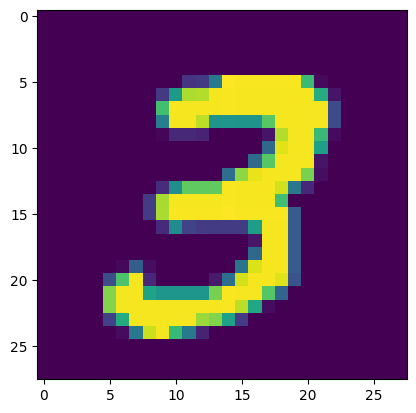

3


In [11]:
#Make predictions for a single image
image, label = testset[7]
plt.imshow(image.numpy().squeeze());
plt.show()

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    model.eval()
    log_ps = model(image)
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    print(top_class.item())